Завантажте в гугл колаб цей ноутбук. У ньому подано інструкції щодо створення нейронної мережі, що розпізнає рукописні цифри. В даному завданні від вас потрібно зробити наступне:

1) Заповнити пропуски у коді.
2) Навчити нейронну мережу.
3) Побудувати необхідні графіки.
4) Знайти помилку мережі.
5) Протестувати роботу мережі на тестових даних.
6) Зробити висновки.

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [5]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features], seed=0), name="w", dtype=tf.float32)
        self.b = tf.Variable(tf.zeros([out_features]), name="b", dtype=tf.float32)

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        # return tf.nn.relu(y)
        return y


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name = "first_layer")

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name = "second_layer")

    # Выходной слой
    self.layer_out = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name = "out_laye")

  def __call__(self, x):
    # Место для вашего кода
    x = self.layer_1(x)
    x = tf.nn.sigmoid(x)
    x = self.layer_2(x)
    x = tf.nn.sigmoid(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    x = self.layer_out(x)
    return tf.nn.softmax(x)

In [7]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    m = tf.keras.metrics.Accuracy()
    m.update_state(y_true, tf.argmax(y_pred, axis=1))
    return m.result().numpy()

In [8]:
def precision(y_pred, y_true):
  p = tf.keras.metrics.Precision()
  p.update_state(y_true, tf.argmax(y_pred, axis=1))
  return p.result()


def recall(y_pred, y_true):
  r = tf.keras.metrics.Recall()
  r.update_state(y_true, tf.argmax(y_pred, axis=1))
  return r.result()

In [9]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = nn(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    t_var = nn.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, t_var)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, t_var))

In [ ]:
from tqdm import tqdm

# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети
precision_history = []
recall_history = []


# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in tqdm(enumerate(train_data.take(training_steps))):
  # batch_x = tf.cast(batch_x, tf.float32)
  # batch_y = tf.cast(batch_y, tf.float32)

  # print(batch_x)
  # print(batch_y)
  train(neural_net, batch_x, batch_y)
  if step % display_step == 0:
      pred = neural_net(batch_x)
      i_loss = cross_entropy(pred, batch_y)
      loss_history.append(i_loss)
      i_accur = accuracy(pred, batch_y)
      accuracy_history.append(i_accur)
      i_pre = precision(pred, batch_y)
      precision_history.append(i_pre)
      i_re = recall(pred, batch_y)
      recall_history.append(i_re)
      print(f"Step {step+1}, Loss: {i_loss:.12f}, Accuracy: {i_accur:.4f}, Precision: {i_pre}, Recall: {i_re}")



1it [00:00,  3.32it/s]

Step 1, Loss: 80.748649597168, Accuracy: 0.9219, Precision: 0.991631805896759, Recall: 1.0


101it [00:26,  3.93it/s]

Step 101, Loss: 90.921859741211, Accuracy: 0.8867, Precision: 1.0, Recall: 0.9914893507957458


201it [00:53,  3.64it/s]

Step 201, Loss: 94.560920715332, Accuracy: 0.8906, Precision: 0.991631805896759, Recall: 0.9957982897758484


301it [01:21,  2.72it/s]

Step 301, Loss: 81.691360473633, Accuracy: 0.9102, Precision: 0.995726466178894, Recall: 0.9914893507957458


401it [01:47,  3.70it/s]

Step 401, Loss: 79.503578186035, Accuracy: 0.9023, Precision: 0.9910714030265808, Recall: 1.0


501it [02:13,  3.69it/s]

Step 501, Loss: 79.283599853516, Accuracy: 0.9102, Precision: 0.9955752491950989, Recall: 0.9911894202232361


601it [02:40,  3.88it/s]

Step 601, Loss: 80.387260437012, Accuracy: 0.9219, Precision: 0.9956331849098206, Recall: 0.991304337978363


701it [03:06,  3.96it/s]

Step 701, Loss: 76.723556518555, Accuracy: 0.9062, Precision: 0.9956896305084229, Recall: 0.9956896305084229


801it [03:34,  3.95it/s]

Step 801, Loss: 53.527198791504, Accuracy: 0.9297, Precision: 0.9956709742546082, Recall: 0.9956709742546082


901it [04:01,  3.27it/s]

Step 901, Loss: 92.159240722656, Accuracy: 0.9141, Precision: 0.995708167552948, Recall: 0.9914529919624329


1001it [04:28,  3.29it/s]

Step 1001, Loss: 63.913482666016, Accuracy: 0.9336, Precision: 0.9956140518188477, Recall: 1.0


1021it [06:33, 32.06s/it]

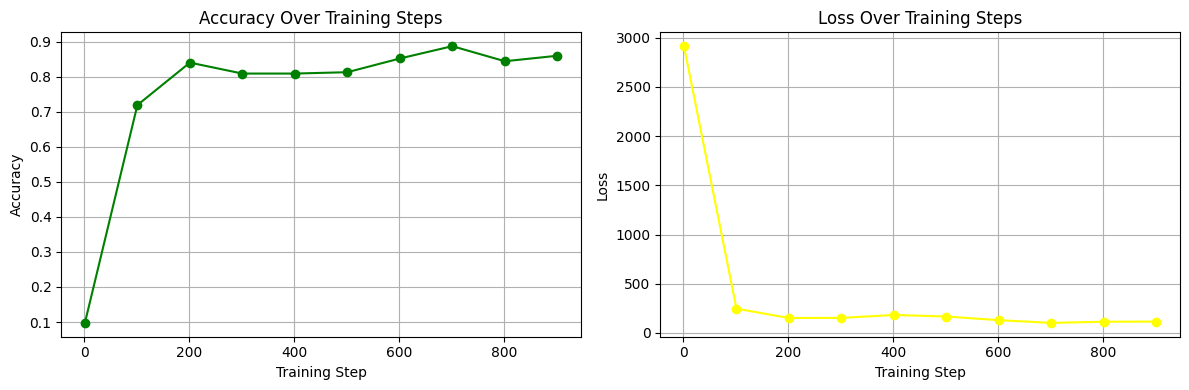

In [11]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
import matplotlib.pyplot as plt

# Створення та налаштування графіків
plt.figure(figsize=(12, 4))

# Графік точності
plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracy_history) * display_step + 1, display_step), accuracy_history, marker='o', color="green")

plt.title('Accuracy Over Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.grid()

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_history) * display_step + 1, display_step), loss_history, marker='o', color="yellow")
plt.title('Loss Over Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid()

# Відображення графіків
plt.tight_layout()
plt.show()

In [12]:
# Вычислите точность обученной нейросети
fin_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {fin_accuracy}")

Accuracy: 0.8744000196456909


True: 8 Predict: 8 True
True: 6 Predict: 6 True
True: 6 Predict: 6 True
True: 3 Predict: 5 False
True: 4 Predict: 4 True
True: 1 Predict: 1 True
True: 4 Predict: 6 False
True: 4 Predict: 4 True
True: 9 Predict: 9 True
True: 1 Predict: 1 True


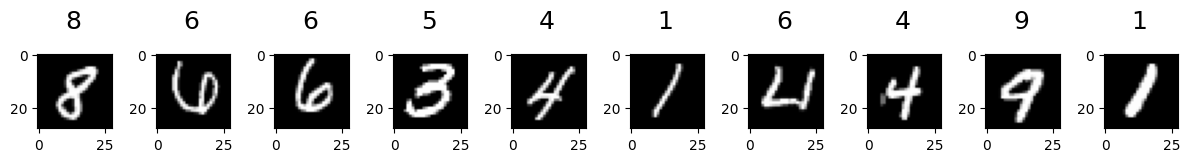

In [20]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]


# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

plt.figure(figsize=(12, 8))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap = "gray")
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()

